In [1]:
from dataloader import DataLoader
loader = DataLoader()

###################################################
# Data Loading
###################################################
df = loader.get_data()

_initialize_data took 80.6562 seconds


In [1]:
import polars as pl
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")

###################################################
# Edge Features
###################################################
edge_feature_cols = [
    "diplo_disagreement",  
    "q",                  
    "v",
    "comrelig",           
    "comlang_off",        
    "distw_harmonic",     
    "pop_o",              
    "pop_d",              
    "gatt_o",             
    "gatt_d",             
    "wto_o",              
    "wto_d",              
    "eu_o",               
    "eu_d",               
    "fta_wto",            
    "entry_cost_o",       
    "entry_cost_d",       
    "tradeflow_baci",     
    "tradeflow_imf_o",    
    "tradeflow_imf_d",
    "total_trade_v"  
]


###################################################
# Reconstruction Attributes
###################################################
recon_attributes = {
    "adj": {"type": "binary"},
    "v": {"type": "continuous", "idx": edge_feature_cols.index("v")},
    "distw_harmonic": {"type": "continuous", "idx": edge_feature_cols.index("distw_harmonic")},
    "wto_o": {"type": "binary", "idx": edge_feature_cols.index("wto_o")},
    "wto_d": {"type": "binary", "idx": edge_feature_cols.index("wto_d")},
    "eu_o": {"type": "binary", "idx": edge_feature_cols.index("eu_o")},
    "eu_d": {"type": "binary", "idx": edge_feature_cols.index("eu_d")},
    "total_trade_v": {"type": "continuous", "idx": edge_feature_cols.index("total_trade_v")}
}


###################################################
# Training Parameters
###################################################
start_year = 2015
n_folds = 5        
epochs = 100       
lr = 0.01

adj_loss_weight = 0.2
attr_loss_weight = 0.8
weight_decay = 1e-4


###################################################
# Device
###################################################
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
###################################################
# Helper Functions
###################################################
def prepare_graph_data(pdf, all_countries, edge_feature_cols, scaler=None):
    """
    Convert a pandas DataFrame of trade data into a graph structure suitable for PyTorch Geometric.

    Parameters
    ----------
    pdf : pd.DataFrame
        Input DataFrame with rows representing edges (export-import pairs).
        Must include 'export_country', 'import_country', and all columns in `edge_feature_cols`.
    all_countries : array-like
        Unique country identifiers found in the data.
    edge_feature_cols : list of str
        Column names of edge features to extract as edge_attr.
    scaler : sklearn.base.Transformer or None, optional
        A fitted scaler (e.g., StandardScaler) to scale the edge attributes.
        If None, attributes are not scaled.

    Returns
    -------
    edge_index : torch.Tensor
        Shape [2, E], edge indices for the graph.
    edge_attr : torch.Tensor
        Shape [E, F], edge attributes after optional scaling.
    """
    country_to_id = {c: i for i, c in enumerate(all_countries)}
    
    src = pdf['export_country'].map(country_to_id)
    dst = pdf['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)
    
    for col in edge_feature_cols:
        pdf[col] = pdf[col].fillna(0.0).astype(float)
        
    edge_attr_values = pdf[edge_feature_cols].values
    if scaler is not None:
        edge_attr_values = scaler.transform(edge_attr_values)
    edge_attr = torch.tensor(edge_attr_values, dtype=torch.float)
    return edge_index, edge_attr


def build_node_features(historical_pdf, all_countries):
    """
    Construct node-level features for each country.

    Currently, this uses historical data to compute:
    - Average GDP as exporter/importer.
    - WTO and EU membership flags.

    Parameters
    ----------
    historical_pdf : pd.DataFrame
        Historical trade data including 'export_country', 'import_country', 'gdpcap_o', 'gdpcap_d',
        'wto_o', 'wto_d', 'eu_o', 'eu_d'.
    all_countries : array-like
        Unique country identifiers.

    Returns
    -------
    x : torch.Tensor
        Node features of shape [N, F], where N = number of countries.
        The features are [avg_gdpcap_o, avg_gdpcap_d, wto_member, eu_member].
    """
    export_gdp = historical_pdf.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = historical_pdf.groupby("import_country")["gdpcap_o"].mean().to_dict()
    
    wto_members = set(historical_pdf[historical_pdf["wto_o"] == 1]["export_country"].unique()) \
                   .union(set(historical_pdf[historical_pdf["wto_d"] == 1]["import_country"].unique()))
    eu_members = set(historical_pdf[historical_pdf["eu_o"] == 1]["export_country"].unique()) \
                  .union(set(historical_pdf[historical_pdf["eu_d"] == 1]["import_country"].unique()))
    
    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        wto_val = 1.0 if c in wto_members else 0.0
        eu_val = 1.0 if c in eu_members else 0.0
        node_features.append([gdp_o_val, gdp_d_val, wto_val, eu_val])
    
    x = torch.tensor(node_features, dtype=torch.float)
    return x

In [4]:
###################################################
# Model Components
###################################################
class GCNEncoder(nn.Module):
    """
    GCN-based encoder for static graphs.

    Parameters
    ----------
    in_channels : int
        Input feature dimension.
    hidden_dim : int
        Hidden dimension for the first GCN layer.
    out_channels : int
        Output embedding dimension.
    dropout : float
        Dropout probability.
    """
    def __init__(self, in_channels, hidden_dim=64, out_channels=32, dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


class TransformerTemporalEncoder(nn.Module):
    """
    Temporal encoder using a Transformer to aggregate node embeddings over time.

    Parameters
    ----------
    emb_dim : int
        Embedding dimension per timestep.
    n_heads : int
        Number of attention heads.
    n_layers : int
        Number of Transformer encoder layers.
    dropout : float
        Dropout probability.
    """
    def __init__(self, emb_dim, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, 
            nhead=n_heads, 
            dim_feedforward=emb_dim*2, 
            dropout=dropout, 
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pos_encoding = self._generate_positional_encoding(1000, emb_dim)


    def _generate_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
    
    
    def forward(self, z_seq):
        T, N, D = z_seq.shape
        pos_enc = self.pos_encoding[:T, :].to(z_seq.device)
        z_seq = z_seq + pos_enc.unsqueeze(1)
        out = self.transformer(z_seq)
        z_final = out[-1, :, :]
        return z_final


class TemporalGNN(nn.Module):
    """
    Temporal GNN that uses a GCNEncoder per snapshot and a TransformerTemporalEncoder across snapshots.

    Parameters
    ----------
    in_channels : int
        Node feature dimension.
    out_channels : int
        Final embedding dimension.
    hidden_dim : int
        GCN hidden dimension.
    dropout : float
        Dropout probability.
    """
    def __init__(self, in_channels, out_channels=32, hidden_dim=64, dropout=0.1):
        super().__init__()
        self.gcn = GCNEncoder(in_channels, hidden_dim=hidden_dim, out_channels=out_channels, dropout=dropout)
        self.temporal_encoder = TransformerTemporalEncoder(emb_dim=out_channels, n_heads=4, n_layers=2, dropout=dropout)
        
        
    def forward(self, x_list, edge_index_list):
        z_seq = []
        for i in range(len(x_list)):
            z_year = self.gcn(x_list[i], edge_index_list[i])
            z_seq.append(z_year.unsqueeze(0))
        z_cat = torch.cat(z_seq, dim=0)
        
        z_final = self.temporal_encoder(z_cat)
        return z_final


class EdgeDecoder(nn.Module):
    """
    Decodes node embeddings to predict edge existence and attributes.

    Parameters
    ----------
    emb_dim : int
        Node embedding dimension.
    recon_attributes : dict
        Specification of attributes to reconstruct.
    """
    def __init__(self, emb_dim, recon_attributes):
        super().__init__()
        self.emb_dim = emb_dim
        self.recon_attributes = recon_attributes
        
        self.adj_bias = nn.Parameter(torch.zeros(1))

        self.binary_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "binary"]
        self.cont_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "continuous"]

        out_dim = len(self.binary_attrs) + len(self.cont_attrs)
        self.mlp = nn.Sequential(
            nn.Linear(2 * emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    
    
    def forward(self, z, edge_index):
        u, v = edge_index
        z_u = z[u]
        z_v = z[v]
        
        scores = (z_u * z_v).sum(dim=-1) + self.adj_bias
        edge_prob = torch.sigmoid(scores)

        edge_input = torch.cat([z_u, z_v], dim=-1)
        out = self.mlp(edge_input) 

        cont_out = out[:, :len(self.cont_attrs)]   
        bin_out = out[:, len(self.cont_attrs):]
        bin_prob = torch.sigmoid(bin_out)

        return edge_prob, cont_out, bin_prob


class GAEModel(nn.Module):
    """
    Graph Autoencoder with a temporal encoder and edge decoder.

    Parameters
    ----------
    encoder : nn.Module
        Temporal encoder (TemporalGNN).
    decoder : nn.Module
        Edge decoder (EdgeDecoder).
    recon_attributes : dict
        Reconstruction attributes specification.
    """
    def __init__(self, encoder, decoder, recon_attributes):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.recon_attributes = recon_attributes
    
    
    def encode(self, x_list, edge_index_list):
        return self.encoder(x_list, edge_index_list)
    
    
    def forward(self, x_list, edge_index_list, edge_index):
        z = self.encode(x_list, edge_index_list)
        return self.decoder(z, edge_index)


    def recon_loss_with_neg(self, z, pos_edge_index, neg_edge_index, pos_edge_attr, recon_attributes, adj_weight=0.2, attr_weight=0.8):
        """
        Compute reconstruction loss using positive and negative edges.
        """
        pos_edge_prob, pos_cont_out, pos_bin_out = self.decoder(z, pos_edge_index)
        neg_edge_prob, neg_cont_out, neg_bin_out = self.decoder(z, neg_edge_index)

        pos_adj_loss = F.binary_cross_entropy(pos_edge_prob, torch.ones_like(pos_edge_prob))
        neg_adj_loss = F.binary_cross_entropy(neg_edge_prob, torch.zeros_like(neg_edge_prob))
        adj_loss = (pos_adj_loss + neg_adj_loss) / 2.0

        cont_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "continuous"]
        bin_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "binary"]

        cont_targets = torch.stack([pos_edge_attr[:, recon_attributes[a]["idx"]] for a in cont_attrs], dim=-1)
        cont_loss = F.mse_loss(pos_cont_out, cont_targets)

        bin_targets = torch.stack([pos_edge_attr[:, recon_attributes[a]["idx"]] for a in bin_attrs], dim=-1)
        bin_loss = F.binary_cross_entropy(pos_bin_out, bin_targets)

        attr_loss = (cont_loss + bin_loss) / 2.0

        total_loss = adj_weight * adj_loss + attr_weight * attr_loss
        return total_loss, adj_loss.item(), cont_loss.item(), bin_loss.item()

In [5]:
def train_model(model, 
                train_data_list, 
                recon_attributes,
                epochs=50, 
                lr=0.01, 
                device=torch.device("cpu"), 
                adj_weight=0.2, 
                attr_weight=0.8, 
                weight_decay=1e-4):
    """
    Train the GAE model on historical + target snapshots.

    Parameters
    ----------
    model : GAEModel
        The GAE model to be trained.
    train_data_list : list of tuples
        Contains (x, edge_index, edge_attr) for historical and target snapshots.
    recon_attributes : dict
        Attributes to reconstruct.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate.
    device : torch.device
        Computation device.
    adj_weight : float
        Weight of adjacency loss.
    attr_weight : float
        Weight of attribute loss.
    weight_decay : float
        L2 regularization factor.
    """
    model.to(device)
    
    x_list = [d[0].to(device) for d in train_data_list[:-1]]
    edge_index_list = [d[1].to(device) for d in train_data_list[:-1]]

    target_data = train_data_list[-1]
    target_x = target_data[0].to(device)
    target_edge_index = target_data[1].to(device)
    target_edge_attr = target_data[2].to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        z = model.encode(x_list + [target_x], edge_index_list + [target_edge_index])
        
        neg_edge_index = negative_sampling(
            edge_index=target_edge_index,
            num_nodes=target_x.size(0),
            num_neg_samples=target_edge_index.size(1)
        ).to(device)
        
        loss, adj_l, cont_l, bin_l = model.recon_loss_with_neg(
            z, 
            target_edge_index, 
            neg_edge_index, 
            target_edge_attr, 
            recon_attributes,
            adj_weight=adj_weight, 
            attr_weight=attr_weight
        )
                
        loss.backward()
        optimizer.step()

In [12]:
@torch.no_grad()
def compute_anomaly_scores(model, 
                           data_list, 
                           recon_attributes, 
                           device: torch.device = torch.device("cpu"), 
                           historical_stats = None,
                           scale_by_num_edges: bool = False):
    """
    Compute anomaly scores for the target year's edges.

    Parameters
    ----------
    model : nn.Module
        Trained GAE model.
    data_list : list of tuples
        (x, edge_index, edge_attr) for historical + target snapshots.
    recon_attributes : dict
        Attributes to reconstruct.
    device : torch.device
        Device for computation.
    historical_stats : dict or None
        Mean and std for normalization of errors.
    scale_by_num_edges : bool
        If True, divide anomaly scores by the number of edges.

    Returns
    -------
    anomaly_scores : np.ndarray
        Array of anomaly scores for each edge in the target snapshot.
    """
    model.to(device)
    model.eval()
    
    x_list = [d[0].to(device) for d in data_list[:-1]]
    edge_index_list = [d[1].to(device) for d in data_list[:-1]]

    target_x = data_list[-1][0].to(device)
    target_edge_index = data_list[-1][1].to(device)
    target_edge_attr = data_list[-1][2].to(device)

    z = model.encode(x_list + [target_x], edge_index_list + [target_edge_index])
    edge_prob, cont_out, bin_out = model.decoder(z, target_edge_index)

    adj_error = -torch.log(edge_prob + 1e-15)

    cont_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "continuous"]
    cont_targets = torch.stack([target_edge_attr[:, recon_attributes[a]["idx"]] for a in cont_attrs], dim=-1)
    cont_errors = (cont_out - cont_targets)**2

    bin_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "binary"]
    bin_targets = torch.stack([target_edge_attr[:, recon_attributes[a]["idx"]] for a in bin_attrs], dim=-1)
    bin_error = -(bin_targets * torch.log(bin_out + 1e-15) + (1 - bin_targets)*torch.log(1 - bin_out + 1e-15))

    all_errors = torch.cat([adj_error.unsqueeze(-1), cont_errors, bin_error], dim=-1)
    errors_np = all_errors.cpu().numpy()

    if historical_stats is not None:
        means = historical_stats["means"]
        stds = historical_stats["stds"]
        stds = np.where(stds == 0, 1e-9, stds)
        z = (errors_np - means) / stds
        anomaly_scores = np.sum(np.abs(z), axis=1)
    
    else:
        anomaly_scores = errors_np.sum(axis=1)

    if scale_by_num_edges:
        num_edges = anomaly_scores.shape[0]
        if num_edges > 0:
            anomaly_scores = anomaly_scores / num_edges

    return anomaly_scores


def compute_historical_stats(model, data_list, recon_attributes, device=torch.device("cpu")):
    """
    Compute historical baseline statistics (means and stds) of reconstruction errors.

    Parameters
    ----------
    model : nn.Module
        Trained GAE model.
    data_list : list of tuples
        (x, edge_index, edge_attr) for historical + target snapshots (last is target).
    recon_attributes : dict
        Attributes to reconstruct.
    device : torch.device
        Device for computation.

    Returns
    -------
    dict
        { "means": means_array, "stds": stds_array }
    """
    model.eval()
    with torch.inference_mode():
        hist_data_list = data_list[:-1]
        all_errors = []

        for single_data in hist_data_list:
            single_x = single_data[0].to(device)
            single_edge_index = single_data[1].to(device)
            single_edge_attr = single_data[2].to(device)
            z = model.encode([single_x], [single_edge_index])
            edge_prob, cont_out, bin_out = model.decoder(z, single_edge_index)

            adj_error = -torch.log(edge_prob + 1e-15)

            cont_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "continuous"]
            bin_attrs = [k for k, v in recon_attributes.items() if k != "adj" and v["type"] == "binary"]

            cont_targets = torch.stack([single_edge_attr[:, recon_attributes[a]["idx"]] for a in cont_attrs], dim=-1)
            cont_errors = (cont_out - cont_targets)**2

            bin_targets = torch.stack([single_edge_attr[:, recon_attributes[a]["idx"]] for a in bin_attrs], dim=-1)
            bin_error = -(bin_targets * torch.log(bin_out+1e-15) + (1-bin_targets)*torch.log(1-bin_out+1e-15))

            all_err = torch.cat([adj_error.unsqueeze(-1), cont_errors, bin_error], dim=-1)
            all_errors.append(all_err.cpu().numpy())
        
        if len(all_errors) > 0:
            all_errors = np.vstack(all_errors)
            means = np.mean(all_errors, axis=0)
            stds = np.std(all_errors, axis=0)
        else:
            num_attrs = 1 + len(cont_attrs) + len(bin_attrs)
            means = np.zeros(num_attrs)
            stds = np.ones(num_attrs)
        
        return {"means": means, "stds": stds}

In [13]:
def run_for_product_year(df, 
                         product, 
                         target_year, 
                         edge_feature_cols, 
                         recon_attributes,
                         n_folds=1, 
                         device=torch.device("cpu"),
                         epochs=50, 
                         lr=0.01, 
                         adj_loss_weight=0.2, 
                         attr_loss_weight=0.8, 
                         weight_decay=1e-4,
                         window_size=1):
    """
    Run the anomaly detection pipeline for a given product and target year with standardized inputs.

    Steps:
    1. Extract historical (before `target_year`) and target-year data for the specified product.
    2. Compute total product-year trade volume for each year and normalize `v` by this total volume,
       making `v` dimensionless and comparable across years and products.
    3. Merge global trade totals and build node-level features.
    4. Apply a StandardScaler to edge features after normalization by total volume.
    5. Construct temporal snapshots and train a temporal GAE model.
    6. Compute historical baseline statistics of reconstruction errors.
    7. Compute normalized anomaly scores for the target year.

    Parameters
    ----------
    df : polars.DataFrame
        Dataset containing columns "t", "k", "export_country", "import_country", "v", and other edge attributes.
    product : int
        Product code of interest.
    target_year : int
        The year to analyze for anomalies.
    edge_feature_cols : list of str
        Names of edge-level features.
    recon_attributes : dict
        Specification of which attributes to reconstruct (binary/continuous).
    n_folds : int, optional
        Number of folds (currently not used).
    device : torch.device, optional
        Computation device (CPU/GPU).
    epochs : int, optional
        Training epochs for the GAE.
    lr : float, optional
        Learning rate.
    adj_loss_weight : float, optional
        Adjacency reconstruction loss weight.
    attr_loss_weight : float, optional
        Attribute reconstruction loss weight.
    weight_decay : float, optional
        L2 regularization.
    window_size : int, optional
        Number of historical years before target_year to use.

    Returns
    -------
    target_mean_score : float or None
        Mean anomaly score for the target year's edges after normalization.
    z_score : float or None
        Same as target_mean_score here, representing the normalized anomaly level.
    num_edges : int or None
        Number of edges in the target snapshot.
    """
    years = df.select(pl.col("t")).unique().to_series().to_list()
    total_trade = (
        df.group_by(["t", "export_country", "import_country"])
          .agg(pl.col("v").sum().alias("total_trade_v"))
          .to_pandas()
    )
    
    historical_years = [y for y in years if y < target_year]
    if len(historical_years) == 0:
        return None, None, None
        
    historical_df = df.filter(pl.col("t").is_in(historical_years) & (pl.col("k") == product))
    target_df = df.filter((pl.col("t") == target_year) & (pl.col("k") == product))

    if target_df.height == 0:
        return None, None, None

    historical_pdf = historical_df.to_pandas()
    target_pdf = target_df.to_pandas()
    
    historical_pdf = historical_pdf.merge(total_trade, on=["t", "export_country", "import_country"], how="left")
    target_pdf = target_pdf.merge(total_trade, on=["t", "export_country", "import_country"], how="left")

    historical_pdf["total_trade_v"] = historical_pdf["total_trade_v"].fillna(0.0)
    target_pdf["total_trade_v"] = target_pdf["total_trade_v"].fillna(0.0)
    
    def normalize_by_year_volume(pdf):
        year_sum = pdf.groupby("t")["v"].transform("sum")
        pdf["v"] = np.where(year_sum == 0, 0, pdf["v"] / year_sum)
        return pdf

    historical_pdf = normalize_by_year_volume(historical_pdf)
    target_pdf = normalize_by_year_volume(target_pdf)
    
    all_countries = np.union1d(
        np.union1d(historical_pdf['export_country'].unique(), historical_pdf['import_country'].unique()),
        np.union1d(target_pdf['export_country'].unique(), target_pdf['import_country'].unique())
    )

    x = build_node_features(historical_pdf, all_countries)

    for col in edge_feature_cols:
        historical_pdf[col] = pd.to_numeric(historical_pdf[col], errors='coerce').fillna(0.0)
        target_pdf[col] = pd.to_numeric(target_pdf[col], errors='coerce').fillna(0.0)
    
    scaler = StandardScaler()
    scaler.fit(historical_pdf[edge_feature_cols])

    last_hist_years = sorted(historical_years)[-window_size:]
    hist_sub_pdf = historical_pdf[historical_pdf['t'].isin(last_hist_years)]
    hist_edge_index, hist_edge_attr = prepare_graph_data(hist_sub_pdf, all_countries, edge_feature_cols, scaler)

    target_edge_index, target_edge_attr = prepare_graph_data(target_pdf, all_countries, edge_feature_cols, scaler)

    train_data_list = [
        (x.clone(), hist_edge_index, hist_edge_attr),
        (x.clone(), target_edge_index, target_edge_attr)
    ]

    encoder_final = TemporalGNN(in_channels=x.size(1), out_channels=32, hidden_dim=64, dropout=0.1)
    decoder_final = EdgeDecoder(emb_dim=32, recon_attributes=recon_attributes)
    final_model = GAEModel(encoder_final, decoder_final, recon_attributes)

    train_model(final_model, train_data_list, recon_attributes, epochs=epochs, lr=lr, device=device,
                adj_weight=adj_loss_weight, attr_weight=attr_loss_weight, weight_decay=weight_decay)

    hist_data_list = [(x.clone(), hist_edge_index, hist_edge_attr)]
    historical_stats = compute_historical_stats(final_model, hist_data_list + [(x.clone(), target_edge_index, target_edge_attr)], recon_attributes, device=device)

    target_data_list = [(x.clone(), target_edge_index, target_edge_attr)]
    target_scores = compute_anomaly_scores(final_model, hist_data_list + target_data_list, 
                                           recon_attributes, device=device, 
                                           historical_stats=historical_stats, 
                                           scale_by_num_edges=False)
    
    target_mean_score = np.mean(target_scores)
    z_score = target_mean_score
    return target_mean_score, z_score, len(target_scores)

In [19]:
###################################################
# Inference
###################################################
start_year = 2008

all_products = [282520,     # Lithium
                280130,     # Fluorine
                271113,     # Petroleum
                760110,     # Aluminium
                750110,     # Nickel mattes
                853400,     # Semicounductors
                721931,     # Steel
                230230,     # Wheat
                180100,     # Cocoa Beans
                270900,     # Crude
                271111,     # Natural Gas
                271129,     # Petroleum Gas
                870323,     # Vehicles (mid-sized engine)
                440729      # Tropical Wood
            ]

all_years = df.select(pl.col("t")).unique().to_series().to_list()
evaluation_years = [y for y in all_years if y >= start_year]

results = []
for product in tqdm(all_products, desc="Processing Products"):
    for year in evaluation_years:
        res = run_for_product_year(df, product, year, edge_feature_cols, recon_attributes,
                                   n_folds=1, device=device, window_size=3)
        target_mean_score, z_score, num_edges = res if res != (None, None, None) else (None, None, None)
        if target_mean_score is not None:
            results.append({
                "product": product,
                "year": year,
                "anomaly_score": target_mean_score,           
                "normalized_anomaly_score": z_score,
                "num_edges": num_edges
            })

results_df = pd.DataFrame(results)
print(results_df.head())

Processing Products: 100%|██████████| 14/14 [2:11:25<00:00, 563.27s/it] 

   product  year  anomaly_score  normalized_anomaly_score  num_edges
0   282520  2022       8.444509                  8.444509        604
1   282520  2010       5.051974                  5.051974        468
2   282520  2013       4.223640                  4.223640        484
3   282520  2016       3.057249                  3.057249        527
4   282520  2019       3.523673                  3.523673        598


In [20]:
results_df

,product,year,anomaly_score,normalized_anomaly_score,num_edges
0,282520,2022,8.444509,8.444509,604
1,282520,2010,5.051974,5.051974,468
2,282520,2013,4.223640,4.223640,484
3,282520,2016,3.057249,3.057249,527
4,282520,2019,3.523673,3.523673,598
...,...,...,...,...,...
205,440729,2009,4.153567,4.153567,2330
206,440729,2018,4.254423,4.254423,2435
207,440729,2012,4.851307,4.851307,2161
208,440729,2015,4.030886,4.030886,2290


In [21]:
###################################################
# Persisting and Reloading of Results
###################################################
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"full_reconstruction_{timestamp}_transformer.csv"
results_df.to_csv(filename, index=False)

results_df = pd.read_csv(filename)
results_df.sort_values(by=["year"], ascending=True, inplace=True)
results_df = results_df.groupby(["product", "year"], as_index=False).mean()

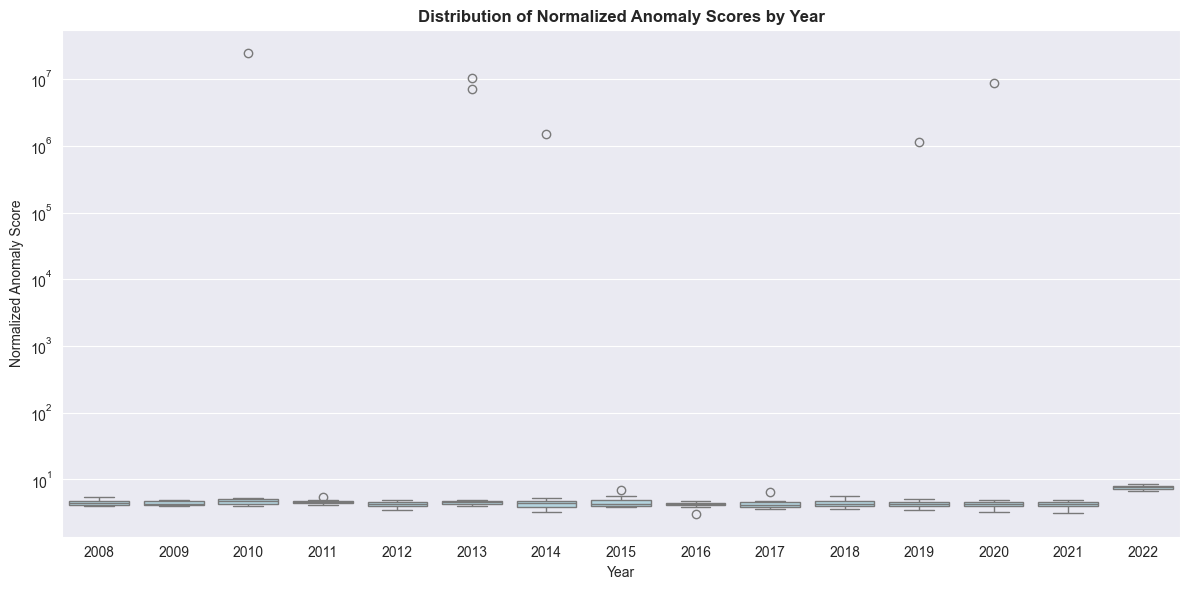

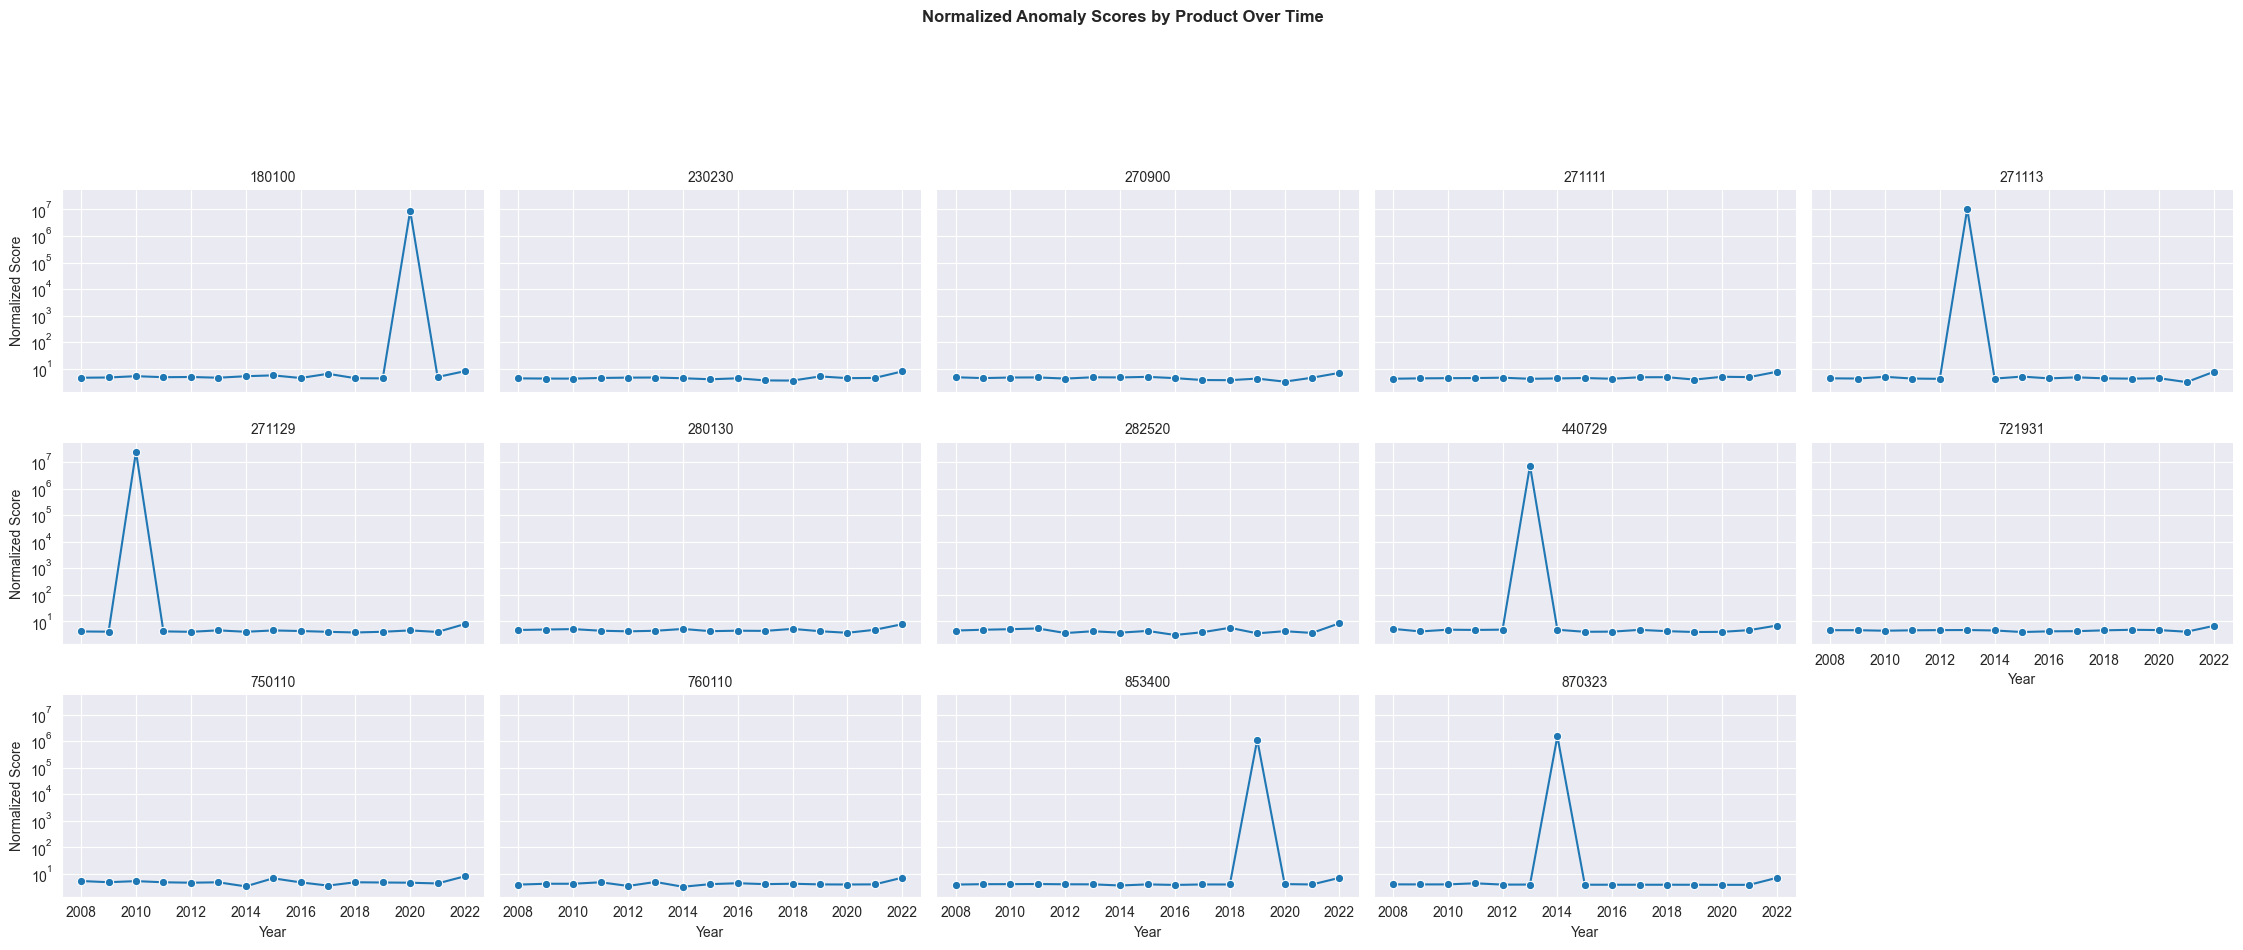

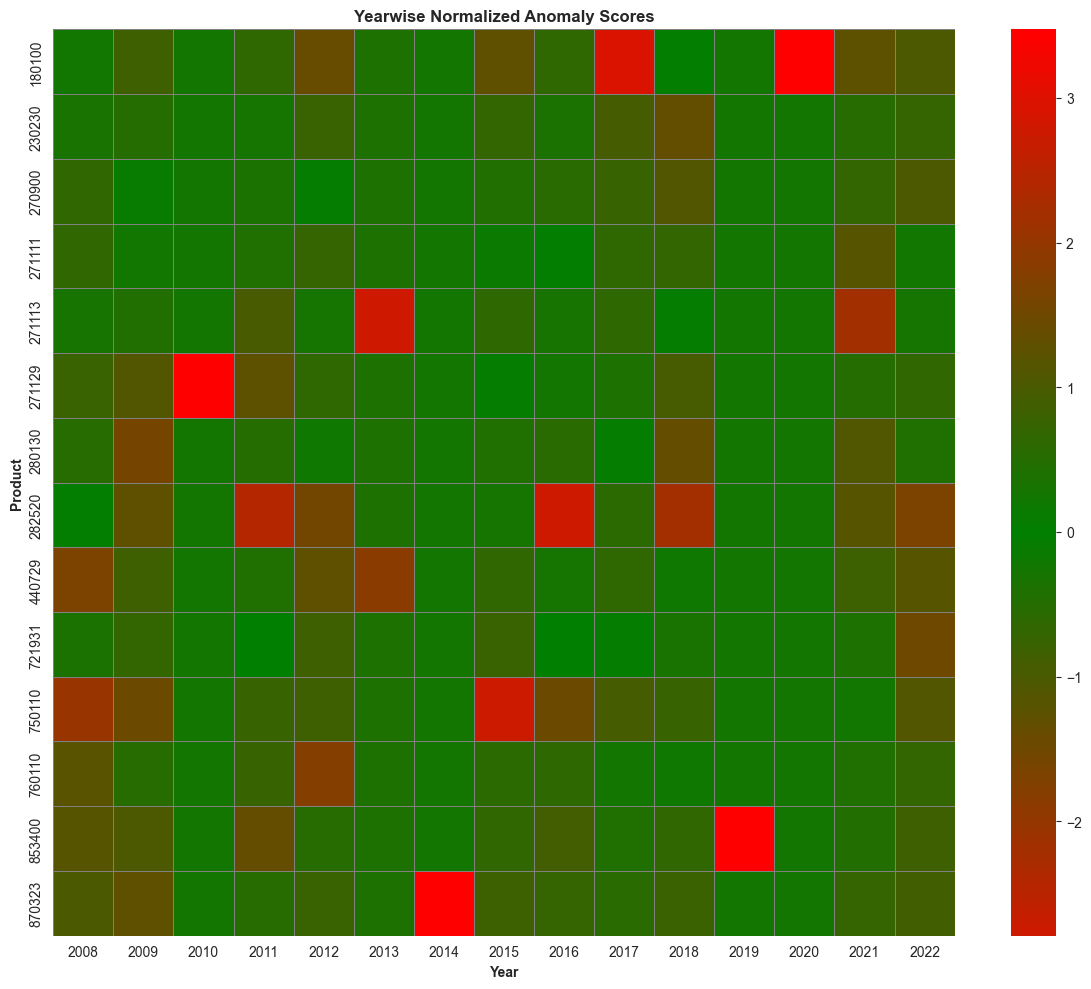

In [22]:
###################################################
# Visualization of Anomaly Scores
###################################################

# Overall distribution of anomaly scores
plt.figure(figsize=(12,6))
sns.boxplot(x="year", y="normalized_anomaly_score", data=results_df, color="lightblue")
plt.yscale('log')
plt.title("Distribution of Normalized Anomaly Scores by Year", fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Normalized Anomaly Score")
plt.tight_layout()
plt.savefig("graphics/boxplot_scores.png", dpi=300)
plt.show()

###################################################

# Trend per product over time
g = sns.FacetGrid(results_df, col="product", col_wrap=5, height=3, aspect=1.5)
g.map(sns.lineplot, "year", "normalized_anomaly_score", marker="o")
g.map(plt.axhline, y=0, color='gray', linestyle='--')
g.set_titles("{col_name}")
g.set(yscale='log')
g.set_axis_labels("Year", "Normalized Score")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Normalized Anomaly Scores by Product Over Time", fontweight="bold", y=1.05)
plt.show()

###################################################

# Anomaly score heatmap
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'RedGreenRed',
    [(0, 'red'), (0.5, 'green'), (1, 'red')]
)

results_df.sort_values(by=["year"], ascending=True, inplace=True)
pivot_df = results_df.pivot(index="product", columns="year", values="normalized_anomaly_score")

pivot_df_norm = pivot_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_df_norm,
    cmap=custom_cmap,
    center=0,
    annot=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Yearwise Normalized Anomaly Scores", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Product", fontweight="bold")
plt.tight_layout()
plt.savefig("graphics/heatmap_yearwise_scaled.png", dpi=300)
plt.show()

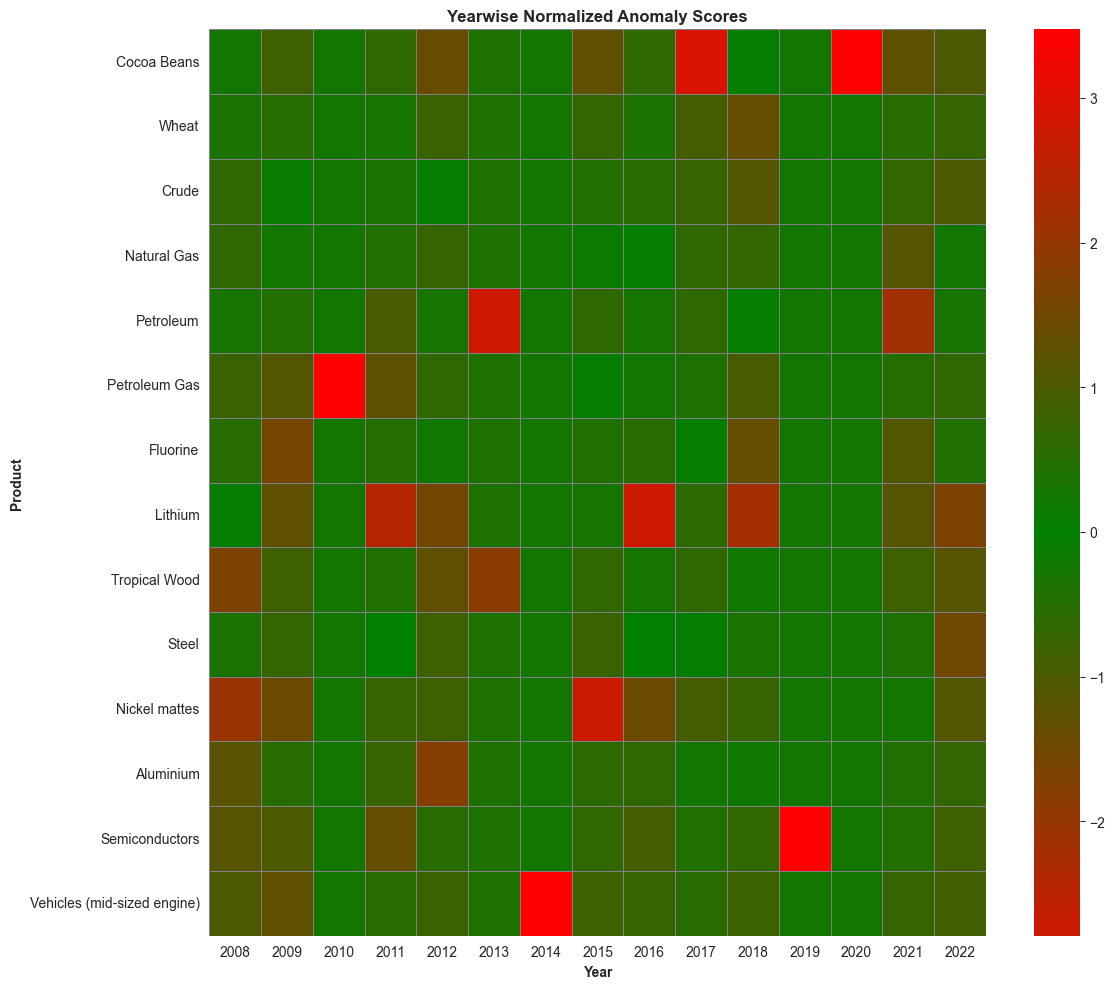

In [23]:
product_dict = {
    282520: "Lithium",
    280130: "Fluorine",
    271113: "Petroleum",
    760110: "Aluminium",
    750110: "Nickel mattes",
    853400: "Semiconductors",
    721931: "Steel",
    230230: "Wheat",
    180100: "Cocoa Beans",
    270900: "Crude",
    271111: "Natural Gas",
    271129: "Petroleum Gas",
    870323: "Vehicles (mid-sized engine)",
    440729: "Tropical Wood"
}

pivot_df.rename(index=product_dict, inplace=True)

pivot_df_norm = pivot_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_df_norm,
    cmap=custom_cmap,
    center=0,
    annot=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Yearwise Normalized Anomaly Scores", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Product", fontweight="bold")
plt.tight_layout()
plt.savefig("graphics/heatmap_yearwise_scaled.png", dpi=300)
plt.show()